[I 2025-05-04 23:52:21,223] A new study created in memory with name: no-name-2549b812-4616-454a-a1f7-2eeeb2181e8d
[I 2025-05-04 23:52:26,239] Trial 0 finished with value: 10188.037564871029 and parameters: {'rolling_volatility_window': 54, 'trix_period': 70, 'tema_period': 39, 'bbands_period': 19, 'macd_fast': 18, 'macd_slow': 37, 'obv_window': 21, 'ewma_span': 22, 'num_leaves': 64, 'learning_rate': 0.05766042612932777, 'n_estimators': 395, 'min_child_samples': 10, 'subsample': 0.8542086649034222, 'colsample_bytree': 0.7064965694881484, 'reg_alpha': 0.7508979091398083, 'reg_lambda': 0.32670462744217615}. Best is trial 0 with value: 10188.037564871029.
[I 2025-05-04 23:52:28,427] Trial 1 finished with value: 10331.768731862925 and parameters: {'rolling_volatility_window': 33, 'trix_period': 27, 'tema_period': 23, 'bbands_period': 26, 'macd_fast': 16, 'macd_slow': 39, 'obv_window': 54, 'ewma_span': 31, 'num_leaves': 33, 'learning_rate': 0.05647735368420424, 'n_estimators': 209, 'min_chil

Final Portfolio Balances:
Dynamic Strategy Final Balance: $10318.62
Balanced Final Balance: $10299.90
Ultra-Aggressive Final Balance: $10337.71


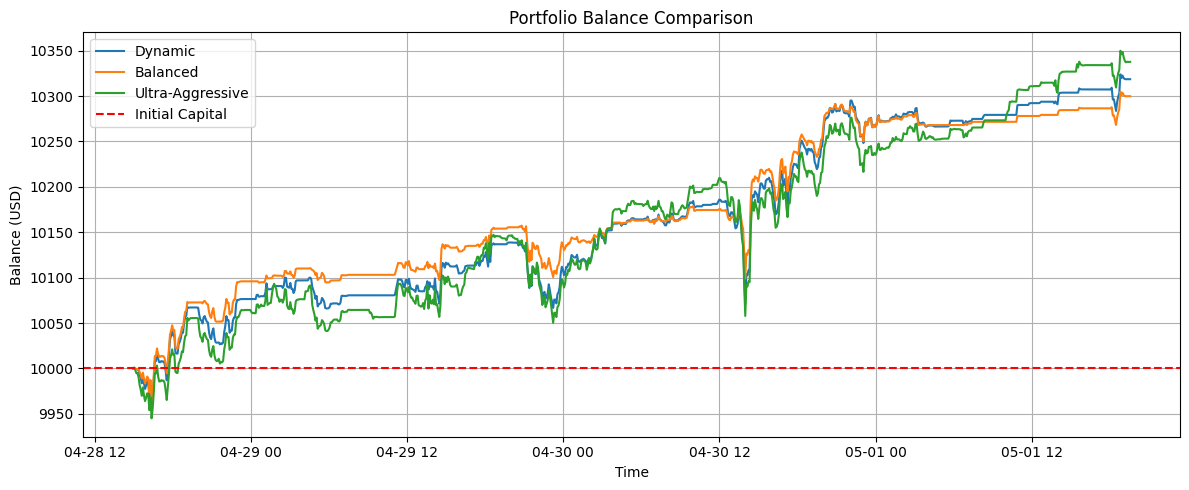


Total process duration: 526.06 seconds (8.77 minutes).


In [ ]:
import json
import os
import time
from datetime import datetime, timedelta

import duckdb
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import talib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# 1. Fetch last 30 days of candles
def fetch_recent_candles(duckdb_file, table_name, days=30):
    now = datetime.utcnow()
    start_time = now - timedelta(days=days)
    query = f"""
        SELECT * FROM {table_name}
        WHERE interval_start >= '{start_time.strftime('%Y-%m-%d %H:%M:%S')}'
        ORDER BY interval_start
    """
    with duckdb.connect(duckdb_file) as conn:
        df = conn.execute(query).fetchdf()
    return df


# 2. Feature engineering (with tunable parameters)
def generate_features(
    candles,
    rolling_volatility_window=30,
    trix_period=30,
    tema_period=30,
    bbands_period=20,
    macd_fast=12,
    macd_slow=26,
    obv_window=30,
    ewma_span=10,
    predict_horizon_minutes=5,  # Fixed
):
    candles = candles.copy()
    candles["interval_start"] = pd.to_datetime(candles["interval_start"])
    candles["interval_end"] = pd.to_datetime(candles["interval_end"])
    candles["future_close"] = candles["close"].shift(-predict_horizon_minutes)
    candles["target_return"] = (candles["future_close"] - candles["close"]) / candles[
        "close"
    ]
    candles["signal"] = (candles["target_return"] > 0).astype(int)

    candles["rolling_volatility"] = (
        candles["close"].rolling(window=rolling_volatility_window).std()
    )
    candles["volume_spike"] = (
        candles["volume"]
        / candles["volume"].rolling(window=rolling_volatility_window).mean()
    )
    candles["minute_of_day"] = (
        candles["interval_start"].dt.hour * 60 + candles["interval_start"].dt.minute
    )
    candles["momentum_5"] = candles["close"].pct_change(5)
    candles["momentum_15"] = candles["close"].pct_change(15)
    candles["range_ratio"] = (candles["high"] - candles["low"]) / candles["close"]
    candles["slope_10"] = candles["close"].diff(10) / 10
    candles["day_of_week"] = candles["interval_start"].dt.dayofweek
    candles["hour_sin"] = np.sin(2 * np.pi * candles["interval_start"].dt.hour / 24)
    candles["hour_cos"] = np.cos(2 * np.pi * candles["interval_start"].dt.hour / 24)

    us_market_open = 13
    asia_market_open = 1
    europe_market_open = 7

    def minutes_from_market(hour, minute, market_hour):
        mins = hour * 60 + minute
        delta = mins - market_hour * 60
        if delta < 0:
            delta += 1440
        return delta

    candles["minutes_from_us_open"] = candles["interval_start"].apply(
        lambda x: minutes_from_market(x.hour, x.minute, us_market_open)
    )
    candles["minutes_from_asia_open"] = candles["interval_start"].apply(
        lambda x: minutes_from_market(x.hour, x.minute, asia_market_open)
    )
    candles["minutes_from_europe_open"] = candles["interval_start"].apply(
        lambda x: minutes_from_market(x.hour, x.minute, europe_market_open)
    )

    for market in ["us", "asia", "europe"]:
        candles[f"norm_{market}_time"] = candles[f"minutes_from_{market}_open"] / 1440
        candles[f"{market}_time_sin"] = np.sin(
            2 * np.pi * candles[f"norm_{market}_time"]
        )
        candles[f"{market}_time_cos"] = np.cos(
            2 * np.pi * candles[f"norm_{market}_time"]
        )

    candles["trix"] = talib.TRIX(candles["close"].values, timeperiod=trix_period)
    candles["tema"] = talib.TEMA(candles["close"].values, timeperiod=tema_period)
    candles["dx"] = talib.DX(
        candles["high"].values,
        candles["low"].values,
        candles["close"].values,
    )
    candles["sar"] = talib.SAR(candles["high"].values, candles["low"].values)
    candles["atr"] = talib.ATR(
        candles["high"].values,
        candles["low"].values,
        candles["close"].values,
    )
    candles["volume_ema"] = candles["volume"].ewm(span=20).mean()
    candles["volume_ratio"] = candles["volume"] / candles["volume_ema"]
    candles["volume_oscillator"] = (
        candles["volume"].rolling(window=5).mean()
        / candles["volume"].rolling(window=20).mean()
        - 1
    ) * 100

    candles["vwap_daily"] = 0.0
    for date in candles["interval_start"].dt.date.unique():
        mask = candles["interval_start"].dt.date == date
        if mask.any():
            candles.loc[mask, "vwap_daily"] = (
                candles.loc[mask, "volume"] * candles.loc[mask, "close"]
            ).cumsum() / candles.loc[mask, "volume"].cumsum()
    candles["vwap_ratio"] = candles["close"] / candles["vwap_daily"].replace(0, np.nan)

    candles["adx"] = talib.ADX(
        candles["high"].values,
        candles["low"].values,
        candles["close"].values,
    )
    candles["adx_strong"] = (candles["adx"] > 25).astype(int)
    candles["obv"] = talib.OBV(candles["close"].values, candles["volume"].values)
    candles["obv_rolling"] = candles["obv"].rolling(window=obv_window).mean()
    candles["willr"] = talib.WILLR(
        candles["high"].values,
        candles["low"].values,
        candles["close"].values,
    )
    candles["mfi"] = talib.MFI(
        candles["high"].values,
        candles["low"].values,
        candles["close"].values,
        candles["volume"].values,
    )
    candles["rsi"] = talib.RSI(candles["close"].values)

    # EWMA features
    candles["ewma_close"] = candles["close"].ewm(span=ewma_span).mean()
    candles["ewma_volume"] = candles["volume"].ewm(span=ewma_span).mean()

    # MACD with optimized fast/slow
    candles["macd"], candles["macd_signal"], candles["macd_hist"] = talib.MACD(
        candles["close"].values, fastperiod=macd_fast, slowperiod=macd_slow
    )

    for period in [5, 10, 20]:
        candles[f"direction_{period}"] = (
            np.sign(candles["close"].diff(period)).fillna(0).astype(int)
        )
        candles[f"sma_{period}"] = candles["close"].rolling(window=period).mean()
        candles[f"above_sma_{period}"] = (
            candles["close"] > candles[f"sma_{period}"]
        ).astype(int)

    sma_5 = candles["close"].rolling(window=5).mean()
    for period in [10, 20]:
        sma_period = candles["close"].rolling(window=period).mean()
        candles[f"ma_crossover_{period}"] = (
            (sma_5 > sma_period) & (sma_5.shift(1) <= sma_period.shift(1))
        ).astype(int)

    candles["bb_upper"], candles["bb_middle"], candles["bb_lower"] = talib.BBANDS(
        candles["close"].values, timeperiod=bbands_period
    )
    candles["bb_width"] = (candles["bb_upper"] - candles["bb_lower"]) / candles[
        "bb_middle"
    ]
    candles["bb_position"] = (candles["close"] - candles["bb_lower"]) / (
        candles["bb_upper"] - candles["bb_lower"]
    )
    candles["atr_ratio"] = candles["atr"] / candles["close"]

    # Additional MACD variants (fixed)
    for fast, slow in [(12, 26), (5, 35)]:
        macd, macd_signal, macd_hist = talib.MACD(
            candles["close"].values, fastperiod=fast, slowperiod=slow
        )
        candles[f"macd_{fast}_{slow}"] = macd
        candles[f"macd_signal_{fast}_{slow}"] = macd_signal
        candles[f"macd_hist_{fast}_{slow}"] = macd_hist
        candles[f"macd_cross_{fast}_{slow}"] = (
            (macd > macd_signal) & (np.roll(macd, 1) <= np.roll(macd_signal, 1))
        ).astype(int)

    candles["time_segment"] = pd.cut(
        candles["minute_of_day"],
        bins=[0, 360, 720, 1080, 1440],
        labels=["night", "morning", "afternoon", "evening"],
    )
    for segment in ["night", "morning", "afternoon", "evening"]:
        candles[f"time_{segment}"] = (candles["time_segment"] == segment).astype(int)

    candles["obv_trend"] = candles["obv"] * candles["adx"]
    candles["volume_volatility"] = (
        candles["volume_ratio"] * candles["rolling_volatility"]
    )
    candles["time_volume"] = candles["minute_of_day"] * candles["volume_ratio"]

    candles.fillna(candles.mean(numeric_only=True), inplace=True)
    return candles


# 3. Prepare train/test split
def prepare_train_test_split(candles, feature_columns):
    cutoff = int(len(candles) * 0.80)
    train_data = candles.iloc[:cutoff]
    test_data = candles.iloc[cutoff:]
    X_train = train_data[feature_columns]
    y_train = train_data["signal"]
    X_test = test_data[feature_columns]
    y_test = test_data["signal"]
    return X_train, y_train, X_test, y_test, train_data, test_data


# 4. Optuna optimization (feature params + model params)
def run_optuna_optimization(df, feature_columns, n_trials=100):
    def objective(trial):
        rolling_volatility_window = trial.suggest_int(
            "rolling_volatility_window", 10, 60
        )
        trix_period = trial.suggest_int("trix_period", 10, 70)
        tema_period = trial.suggest_int("tema_period", 10, 70)
        bbands_period = trial.suggest_int("bbands_period", 10, 40)
        macd_fast = trial.suggest_int("macd_fast", 1, 19)
        macd_slow = trial.suggest_int("macd_slow", macd_fast + 1, 40)
        obv_window = trial.suggest_int("obv_window", 5, 60)
        ewma_span = trial.suggest_int("ewma_span", 3, 40)

        try:
            candles = generate_features(
                df,
                rolling_volatility_window=rolling_volatility_window,
                trix_period=trix_period,
                tema_period=tema_period,
                bbands_period=bbands_period,
                macd_fast=macd_fast,
                macd_slow=macd_slow,
                obv_window=obv_window,
                ewma_span=ewma_span,
                predict_horizon_minutes=5,
            )
        except Exception as e:
            raise optuna.TrialPruned()

        X_train, y_train, X_test, y_test, train_data, test_data = (
            prepare_train_test_split(candles, feature_columns)
        )

        params = {
            "objective": "binary",
            "num_leaves": trial.suggest_int("num_leaves", 30, 70),
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.08),
            "n_estimators": trial.suggest_int("n_estimators", 200, 500),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 30),
            "subsample": trial.suggest_float("subsample", 0.65, 0.9),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.6, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.2, 1.0),
            "class_weight": "balanced",
            "verbosity": -1,
        }
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        sim_dyn = run_simulation(test_data, y_pred, y_proba, "dynamic")
        sim_bal = run_simulation(test_data, y_pred, y_proba, "balanced")
        sim_ultra = run_simulation(test_data, y_pred, y_proba, "ultra_aggressive")
        return (
            sim_dyn["balance"].iloc[-1]
            + sim_bal["balance"].iloc[-1]
            + sim_ultra["balance"].iloc[-1]
        ) / 3

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params


# 5. Simulation function
def run_simulation(sim_data, y_pred, y_pred_proba, strategy, initial_balance=10000):
    balance_history = []
    balance = initial_balance
    position = 0
    sim_data = sim_data.copy()
    sim_data["predicted"] = y_pred
    sim_data["predicted_proba"] = y_pred_proba
    for i in range(0, len(sim_data), 5):
        row = sim_data.iloc[i]
        price = row["close"]
        signal = row["predicted"]
        confidence = row["predicted_proba"]
        if strategy == "dynamic":
            if signal == 1 and confidence > 0.55 and balance > 0:
                position_size = balance * min(0.25 + (confidence - 0.55), 0.5)
                units = position_size / price
                position += units
                balance -= position_size
            elif signal == 0 and position > 0:
                units_to_sell = position * 0.75
                balance += units_to_sell * price
                position -= units_to_sell
        elif strategy == "balanced":
            if signal == 1 and confidence > 0.6 and balance > 0:
                position_size = balance * 0.25
                units = position_size / price
                position += units
                balance -= position_size
            elif signal == 0 and position > 0:
                units_to_sell = position * 0.75
                balance += units_to_sell * price
                position -= units_to_sell
        elif strategy == "ultra_aggressive":
            if signal == 1 and confidence > 0.5 and balance > 0:
                position_size = min(balance * 0.5, balance)
                units = position_size / price
                position += units
                balance -= position_size
            elif signal == 0 and position > 0:
                units_to_sell = position * 0.5
                balance += units_to_sell * price
                position -= units_to_sell
        current_balance = balance + (position * price if position > 0 else 0)
        balance_history.append((row["interval_start"], current_balance))
    return pd.DataFrame(balance_history, columns=["time", "balance"])


# 6. Plotting and printing balances
def plot_and_print_balances(
    balance_df_dyn, balance_df_bal, balance_df_ultra, initial_balance=10000
):
    print("Final Portfolio Balances:")
    print(f"Dynamic Strategy Final Balance: ${balance_df_dyn['balance'].iloc[-1]:.2f}")
    print(f"Balanced Final Balance: ${balance_df_bal['balance'].iloc[-1]:.2f}")
    print(
        f"Ultra-Aggressive Final Balance: ${balance_df_ultra['balance'].iloc[-1]:.2f}"
    )

    plt.figure(figsize=(12, 5))
    plt.plot(balance_df_dyn["time"], balance_df_dyn["balance"], label="Dynamic")
    plt.plot(balance_df_bal["time"], balance_df_bal["balance"], label="Balanced")
    plt.plot(
        balance_df_ultra["time"], balance_df_ultra["balance"], label="Ultra-Aggressive"
    )
    plt.axhline(y=initial_balance, color="red", linestyle="--", label="Initial Capital")
    plt.title("Portfolio Balance Comparison")
    plt.xlabel("Time")
    plt.ylabel("Balance (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def train_on_full_data(candles, feature_columns, best_params):
    X_full = candles[feature_columns]
    y_full = candles["signal"]
    final_model = lgb.LGBMClassifier(**best_params)
    final_model.fit(X_full, y_full)
    return final_model


def save_model(model, model_dir="/data/models"):
    os.makedirs(model_dir, exist_ok=True)
    now_str = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(model_dir, f"run_{now_str}")
    os.makedirs(run_dir, exist_ok=True)
    model_path = os.path.join(run_dir, "model.pkl")
    joblib.dump(model, model_path)
    # Atomic update for latest.pkl
    tmp_path = os.path.join(model_dir, "latest_tmp.pkl")
    latest_path = os.path.join(model_dir, "latest.pkl")
    joblib.dump(model, tmp_path)
    os.replace(tmp_path, latest_path)  # Atomic on most OSes
    return run_dir, model_path, latest_path


def save_metadata(
    run_dir,
    best_params,
    accuracy,
    precision,
    recall,
    f1,
    balance_df_dyn,
    balance_df_bal,
    balance_df_ultra,
    duration,
    model_dir="/data/models",
):
    now_str = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    metrics = {
        "timestamp": now_str,
        "best_params": best_params,
        "accuracy": round(accuracy, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4),
        "duration_seconds": round(duration, 2),
        "portfolio_balances": {
            "dynamic": round(balance_df_dyn["balance"].iloc[-1], 2),
            "balanced": round(balance_df_bal["balance"].iloc[-1], 2),
            "ultra_aggressive": round(balance_df_ultra["balance"].iloc[-1], 2),
        },
    }
    # Save to run-specific folder atomically
    metrics_path = os.path.join(run_dir, "metrics.json")
    tmp_metrics_path = os.path.join(run_dir, "metrics_tmp.json")
    with open(tmp_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    os.replace(tmp_metrics_path, metrics_path)  # Atomic move

    # Also save as latest.json in the model_dir atomically
    latest_metrics_path = os.path.join(model_dir, "latest.json")
    tmp_latest_metrics_path = os.path.join(model_dir, "latest_tmp.json")
    with open(tmp_latest_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    os.replace(tmp_latest_metrics_path, latest_metrics_path)  # Atomic move

    return metrics_path, latest_metrics_path


def main():
    start_time = time.time()  # Start timer for the whole process

    duckdb_file = "/data/crypto.duckdb"
    table_name = "candles"
    initial_balance = 10000

    feature_columns = [
        "rsi",
        "macd",
        "macd_signal",
        "macd_hist",
        "adx",
        "obv",
        "obv_rolling",
        "willr",
        "mfi",
        "trix",
        "tema",
        "dx",
        "sar",
        "atr",
        "rolling_volatility",
        "volume_spike",
        "minute_of_day",
        "momentum_5",
        "momentum_15",
        "range_ratio",
        "slope_10",
        "day_of_week",
        "hour_sin",
        "hour_cos",
        "minutes_from_us_open",
        "minutes_from_asia_open",
        "minutes_from_europe_open",
        "us_time_sin",
        "us_time_cos",
        "asia_time_sin",
        "asia_time_cos",
        "europe_time_sin",
        "europe_time_cos",
        "volume_ema",
        "volume_ratio",
        "volume_oscillator",
        "vwap_ratio",
        "adx_strong",
        "direction_5",
        "direction_10",
        "direction_20",
        "above_sma_5",
        "above_sma_10",
        "above_sma_20",
        "bb_width",
        "bb_position",
        "atr_ratio",
        "macd_12_26",
        "macd_signal_12_26",
        "macd_hist_12_26",
        "macd_5_35",
        "macd_signal_5_35",
        "macd_hist_5_35",
        "macd_cross_12_26",
        "macd_cross_5_35",
        "time_night",
        "time_morning",
        "time_afternoon",
        "time_evening",
        "obv_trend",
        "volume_volatility",
        "time_volume",
        "ewma_close",
        "ewma_volume",
    ]

    df = fetch_recent_candles(duckdb_file, table_name)
    best_params = run_optuna_optimization(df, feature_columns, n_trials=200)

    # Extract feature params for final feature generation
    feature_param_keys = [
        "rolling_volatility_window",
        "trix_period",
        "tema_period",
        "bbands_period",
        "macd_fast",
        "macd_slow",
        "obv_window",
        "ewma_span",
    ]
    feature_params = {k: best_params[k] for k in feature_param_keys}
    model_params = {k: v for k, v in best_params.items() if k not in feature_param_keys}

    candles = generate_features(df, **feature_params, predict_horizon_minutes=5)
    X_train, y_train, X_test, y_test, train_data, test_data = prepare_train_test_split(
        candles, feature_columns
    )
    best_model = lgb.LGBMClassifier(**model_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    balance_df_dyn = run_simulation(
        test_data, y_pred, y_pred_proba, "dynamic", initial_balance
    )
    balance_df_bal = run_simulation(
        test_data, y_pred, y_pred_proba, "balanced", initial_balance
    )
    balance_df_ultra = run_simulation(
        test_data, y_pred, y_pred_proba, "ultra_aggressive", initial_balance
    )

    plot_and_print_balances(
        balance_df_dyn, balance_df_bal, balance_df_ultra, initial_balance
    )

    # Train on full data and save model
    final_model = train_on_full_data(candles, feature_columns, model_params)
    run_dir, model_path, latest_path = save_model(final_model, model_dir="/data/models")
    end_time = time.time()
    duration = end_time - start_time
    save_metadata(
        run_dir,
        best_params,
        accuracy,
        precision,
        recall,
        f1,
        balance_df_dyn,
        balance_df_bal,
        balance_df_ultra,
        duration,
    )

    print(
        f"\nTotal process duration: {duration:.2f} seconds ({duration/60:.2f} minutes)."
    )


if __name__ == "__main__":
    # 50 * * * * /usr/bin/python3 /path/to/train.py
    main()
